In [1]:
import os
import pandas as pd
import numpy as np
import tiktoken
import openai
import PyPDF2
from scipy import spatial
from collections import deque
from dotenv import load_dotenv

load_dotenv()

OPENAI_KEY = os.getenv("OPENAI_KEY")

In [2]:
# Ссылка на источник статьи: https://openai.com/index/evolution-strategies/
reader = PyPDF2.PdfReader("Evolution_Strategies_as_a_scalable_alternative_to_Reinforcement.pdf")
f"Total pages: {len(reader.pages)}"

'Total pages: 13'

In [3]:
page_0 = reader.pages[0]
page_0.extract_text()

'Evolution Strategies as a\nScalable Alternative to Reinforcement Learning\nTim Salimans Jonathan Ho Xi Chen Szymon Sidor Ilya Sutskever\nOpenAI\nAbstract\nWe explore the use of Evolution Strategies (ES), a class of black box optimization\nalgorithms, as an alternative to popular MDP-based RL techniques such as Q-\nlearning and Policy Gradients. Experiments on MuJoCo and Atari show that ES\nis a viable solution strategy that scales extremely well with the number of CPUs\navailable: By using a novel communication strategy based on common random\nnumbers, our ES implementation only needs to communicate scalars, making it\npossible to scale to over a thousand parallel workers. This allows us to solve 3D\nhumanoid walking in 10 minutes and obtain competitive results on most Atari\ngames after one hour of training. In addition, we highlight several advantages of\nES as a black box optimization technique: it is invariant to action frequency and\ndelayed rewards, tolerant of extremely long ho

In [4]:
# page_0

In [5]:
def remove_newlines(ser: pd.Series):
    ser = ser.str.replace("\n", ' ')
    ser = ser.str.replace("\\n", ' ')
    ser = ser.str.replace("  ", ' ')
    ser = ser.str.replace("  ", ' ')
    return ser

In [6]:
texts = []
for idx, page in enumerate(reader.pages):
    texts.append((f"page {idx}", page.extract_text()))

df = pd.DataFrame(texts, columns=["page", "text"])
df.head(10)

,page,text
0,page 0,Evolution Strategies as a\nScalable Alternativ...
1,page 1,reduction in required computation of roughly 3...
2,page 2,"setEθ∼pψF(θ) =E/epsilon1∼N(0,I)F(θ+σ/epsilon1)..."
3,page 3,"independent across iterations, we did not ﬁnd ..."
4,page 4,"ment or policy, or may only be available as hi..."
5,page 5,3.2 Problem dimensionality\nThe gradient estim...
6,page 6,4 Experiments\n4.1 MuJoCo\nWe evaluated ES on ...
7,page 7,"10210310110218 cores, 657 minutes\n1440 cores,..."
8,page 8,6 Conclusion\nWe have explored Evolution Strat...
9,page 9,Kenji Kawaguchi. Deep learning without poor lo...


In [7]:
df["text"] = df["page"] + ". " + remove_newlines(df["text"])
df

,page,text
0,page 0,page 0. Evolution Strategies as a Scalable Alt...
1,page 1,page 1. reduction in required computation of r...
2,page 2,"page 2. setEθ∼pψF(θ) =E/epsilon1∼N(0,I)F(θ+σ/e..."
3,page 3,"page 3. independent across iterations, we did ..."
4,page 4,"page 4. ment or policy, or may only be availab..."
5,page 5,page 5. 3.2 Problem dimensionality The gradien...
6,page 6,page 6. 4 Experiments 4.1 MuJoCo We evaluated ...
7,page 7,"page 7. 10210310110218 cores, 657 minutes 1440..."
8,page 8,page 8. 6 Conclusion We have explored Evolutio...
9,page 9,page 9. Kenji Kawaguchi. Deep learning without...


In [8]:
df.to_csv("Evolution_Strategies_as_a_scalable_alternative_to_Reinforcement.csv")

In [9]:
tokenizer = tiktoken.get_encoding("cl100k_base")

df_1 = pd.read_csv("Evolution_Strategies_as_a_scalable_alternative_to_Reinforcement.csv", index_col=0)
df_1.columns = ["title", "text"]

df_1

,title,text
0,page 0,page 0. Evolution Strategies as a Scalable Alt...
1,page 1,page 1. reduction in required computation of r...
2,page 2,"page 2. setEθ∼pψF(θ) =E/epsilon1∼N(0,I)F(θ+σ/e..."
3,page 3,"page 3. independent across iterations, we did ..."
4,page 4,"page 4. ment or policy, or may only be availab..."
5,page 5,page 5. 3.2 Problem dimensionality The gradien...
6,page 6,page 6. 4 Experiments 4.1 MuJoCo We evaluated ...
7,page 7,"page 7. 10210310110218 cores, 657 minutes 1440..."
8,page 8,page 8. 6 Conclusion We have explored Evolutio...
9,page 9,page 9. Kenji Kawaguchi. Deep learning without...


In [10]:
# text_series = df_1.iloc[:, 1].astype("str")
# text_series

In [11]:
# text_string = " ".join(text_series)
# text_string

In [12]:
# len(text_string)

<Axes: >

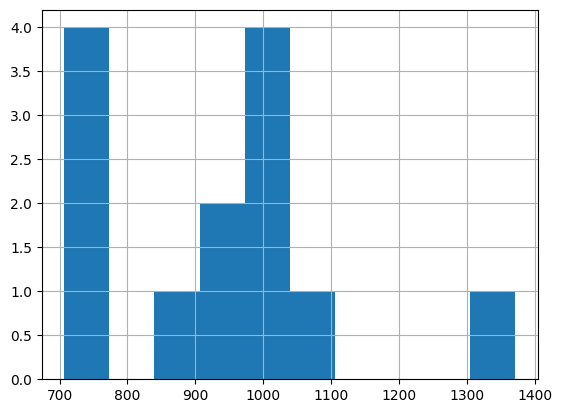

In [13]:
df_1["n_tokens"] = df_1.text.apply(lambda x: len(tokenizer.encode(x)))

df_1.n_tokens.hist()

In [14]:
max_tokens = 500

def split_into_many(text, max_tokens=max_tokens):
    sentences = text.split(". ")

    n_tokens = [len(tokenizer.encode(' ' + sentence)) for sentence in sentences]

    chunks = []
    tokens_so_far = 0
    chunk = []

    for sentence, token in zip(sentences, n_tokens):
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + '.')
            chunk = []
            tokens_so_far = 0

        if token > max_tokens:
            continue

        chunk.append(sentence)
        tokens_so_far += token + 1
    
    return chunks

In [15]:
shortened = []

for row in df_1.iterrows():
    if row[1]["text"] is None:
        continue

    if row[1]["n_tokens"] > max_tokens:
        shortened += split_into_many(row[1]["text"])
    else:
        shortened.append(row[1]["text"])

In [16]:
df_1

,title,text,n_tokens
0,page 0,page 0. Evolution Strategies as a Scalable Alt...,736
1,page 1,page 1. reduction in required computation of r...,1057
2,page 2,"page 2. setEθ∼pψF(θ) =E/epsilon1∼N(0,I)F(θ+σ/e...",858
3,page 3,"page 3. independent across iterations, we did ...",1032
4,page 4,"page 4. ment or policy, or may only be availab...",1013
5,page 5,page 5. 3.2 Problem dimensionality The gradien...,1010
6,page 6,page 6. 4 Experiments 4.1 MuJoCo We evaluated ...,960
7,page 7,"page 7. 10210310110218 cores, 657 minutes 1440...",744
8,page 8,page 8. 6 Conclusion We have explored Evolutio...,947
9,page 9,page 9. Kenji Kawaguchi. Deep learning without...,1007


<Axes: >

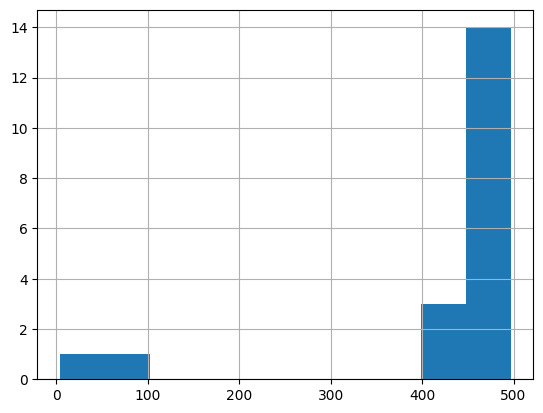

In [17]:
df_2 = pd.DataFrame(shortened, columns=["text"])
df_2["n_tokens"] = df_2.text.apply(lambda x: len(tokenizer. encode(x)))
df_2.n_tokens.hist()

In [18]:
client = openai.OpenAI(api_key=OPENAI_KEY)

In [19]:
df_2["embeddings"] = df_2["text"].apply(lambda x: client.embeddings.create(input=x, model="text-embedding-3-large").data[0].embedding)

df_2

,text,n_tokens,embeddings
0,page 0. Evolution Strategies as a Scalable Alt...,481,"[0.0031754651572555304, 0.0026524243876338005,..."
1,page 1. reduction in required computation of r...,490,"[0.018670832738280296, -0.0006956871366128325,..."
2,Algorithms in this class differ in how they re...,497,"[0.013223128393292427, -0.01103265956044197, -..."
3,"page 2. setEθ∼pψF(θ) =E/epsilon1∼N(0,I)F(θ+σ/e...",490,"[-0.007588182110339403, 0.00027525381301529706..."
4,"page 3. independent across iterations, we did ...",480,"[0.007822955958545208, -0.00798095390200615, -..."
5,"For example, by setting mto be equal to twice ...",494,"[0.022733906283974648, 0.009539417922496796, -..."
6,"page 4. ment or policy, or may only be availab...",435,"[0.012697719968855381, -0.015324583277106285, ..."
7,It can be interpreted as adding a Gaussian blu...,490,"[1.9825974959530868e-05, 0.011389529332518578,..."
8,page 5. 3.2 Problem dimensionality The gradien...,457,"[0.004575987346470356, 0.006436553783714771, -..."
9,We hypothesize that this is due to the same ef...,491,"[0.01814691349864006, -0.01686204969882965, -0..."


In [20]:
df_2.to_csv("Evolution_Strategies_as_a_scalable_alternative_to_Reinforcement_embed.csv")

In [21]:
def distances_from_embeddings(query_embedding, embeddings, dist_metric="cosine"):
    distance_metrics = {
        "cosine": spatial.distance.cosine,
        "L1": spatial.distance.cityblock,
        "L2": spatial.distance.euclidean,
        "Linf": spatial.distance.chebyshev
    }
    dist = [distance_metrics[dist_metric](query_embedding, embedding) for embedding in embeddings]
    return dist

In [22]:
df_3 = pd.read_csv("Evolution_Strategies_as_a_scalable_alternative_to_Reinforcement_embed.csv", index_col=0)
df_3["embeddings"] = df_3["embeddings"].apply(eval).apply(np.array)

df_3.head()

,text,n_tokens,embeddings
0,page 0. Evolution Strategies as a Scalable Alt...,481,"[0.0031754651572555304, 0.0026524243876338005,..."
1,page 1. reduction in required computation of r...,490,"[0.018670832738280296, -0.0006956871366128325,..."
2,Algorithms in this class differ in how they re...,497,"[0.013223128393292427, -0.01103265956044197, -..."
3,"page 2. setEθ∼pψF(θ) =E/epsilon1∼N(0,I)F(θ+σ/e...",490,"[-0.007588182110339403, 0.00027525381301529706..."
4,"page 3. independent across iterations, we did ...",480,"[0.007822955958545208, -0.00798095390200615, -..."


In [23]:
def create_context(question: str, df: pd.DataFrame, max_len=1000):
    q_embeddings = client.embeddings.create(input=question, model="text-embedding-3-large").data[0].embedding

    df["distances"] = distances_from_embeddings(q_embeddings, df["embeddings"].values)

    returns = []
    cur_len = 0

    for i, row in df.sort_values("distances", ascending=True).iterrows():
        cur_len += row["n_tokens"] + 4
        if cur_len > max_len:
            break
        returns.append(row["text"])

    return "\n\n###\n\n".join(returns)

In [24]:
system_prompt = (
    "Ты бот-помощник в задачах, связанных с ответами на вопросы. "
    "При первом знакомстве представляйся и кратко расскажи кто ты такой. "
    "Ничего не выдумывай. "
    "Если не знаешь ответа, скажи, что не знаешь. "
    # "Используй максимум четыре предложения и будь краток. "
    "Пиши вежливо, красиво, делай абзацы с отступами сверху и снизу. "
    "При приветствии учитывай временную зону, которая +05:00. "
    "\n\n"
    "Ссылка на источник статьи: https://openai.com/index/evolution-strategies/ "
    "\n\n"
    "Документ: {context} "
    "\n\n"
    "Твоё имя: {bot_name} "
    "\n\n"
)

In [25]:
chat_history = deque(maxlen=10)

def answer_question(
    question: str,
    df: pd.DataFrame,
    model: str = "gpt-3.5-turbo",
    max_len=1800,
    debug=False,
    max_tokens=1500,
    stop_sequence=None,
    chat_history=None
):
        
    context = create_context(
        question,
        df,
        max_len=max_len
    )

    if debug:
        print(f"Context:\n{context}")
        print("\n\n")

    try:
        response = client.chat.completions.create(
            model=model,
            # messages=[
            #     {"role": "system", "content": system_prompt.format(bot_name="T-800")},
            #     {"role": "user", "content": f"Context: {context}\n\n---\n\nQuestion: {question}\nAnswer:"}
            # ],
            messages=[
                {"role": "system", "content": system_prompt.format(context=context, bot_name="T-800")},
                *([] if chat_history is None else list(chat_history)),
                {"role": "user", "content": f"Вопрос: {question}\nОтвет:"}
            ],
            temperature=0.0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence
        )

        answer = response.choices[0].message.content
        
        if chat_history is not None:
            chat_history.append({"role": "user", "content": question})
            chat_history.append({"role": "assistant", "content": answer})

        return answer
    except Exception as e:
        print(e)
        return ""

In [29]:
q = "Briefly tell us what you know about evolutionary strategy"

answer_question(q, df_3, debug=False, chat_history=chat_history)

'Эволюционные стратегии (ES) - это класс алгоритмов оптимизации "черного ящика", вдохновленных естественной эволюцией. На каждой итерации популяция параметров подвергается мутациям, и их целевая функция оценивается. Лучшие параметры затем комбинируются для создания следующего поколения. ES позволяют эффективно обучать нейронные сети для управления роботами в физических симуляторах и играть в игры Atari с пиксельным вводом. ES демонстрируют хорошую масштабируемость на современных распределенных системах и имеют ряд преимуществ, таких как инвариантность к частоте действий, способность работать с длительными горизонтами планирования и отсутствие необходимости в дисконтировании времени или аппроксимации функции ценности.'

In [30]:
q = "What is the advantage of ES over RL?"

answer_question(q, df_3, debug=False, chat_history=chat_history)

'Эволюционные стратегии (ES) имеют ряд преимуществ перед техниками обучения с подкреплением (RL), которые вычисляют градиенты. Вот некоторые из них:\n\n1. Необходимость в вычислении градиентов: ES не требуют вычисления градиентов, что уменьшает объем вычислений на каждой итерации обучения примерно на две трети и позволяет сократить использование памяти.\n\n2. Обработка разреженных и отложенных вознаграждений: ES способны работать с максимально разреженными и отложенными вознаграждениями, используя только общее вознаграждение эпизода, в то время как другие методы RL требуют индивидуальных вознаграждений и их точного времинга.\n\n3. Защита от проблем с взрывающимися градиентами: Поскольку ES не требуют обратного распространения ошибки, они защищены от проблем с взрывающимися градиентами, что часто возникает при работе с рекуррентными нейронными сетями.\n\n4. Низкая чувствительность к аппаратному обеспечению низкой точности: ES хорошо работают на аппаратуре с низкой точностью для глубоког

In [31]:
q = "Расскажи в кратце о чем идет речь в статье контекста"

answer_question(q, df_3, debug=False, chat_history=chat_history)

'Статья рассматривает применение эволюционных стратегий (ES) как альтернативы популярным методам обучения с подкреплением на основе MDP, таким как Q-обучение и градиенты политики. Эксперименты на MuJoCo и Atari показывают, что ES является эффективным стратегическим решением, которое масштабируется очень хорошо с увеличением числа ЦПУ. С помощью новой стратегии общения на основе общих случайных чисел реализация ES требует обмена только скалярами, что позволяет масштабироваться до более тысячи параллельных рабочих. Это позволяет решить проблему ходьбы трехмерного человека за 10 минут и получить конкурентоспособные результаты почти во всех играх Atari после одного часа обучения. Кроме того, статья выделяет несколько преимуществ ES как техники оптимизации "черного ящика", таких как инвариантность к частоте действий, способность работать с длительными горизонтами, отсутствие необходимости дисконтирования времени или аппроксимации функции ценности.'

In [32]:
q = "Откуда статья?"

answer_question(q, df_3, debug=False, chat_history=chat_history)

'Статья взята с официального сайта OpenAI по адресу: https://openai.com/index/evolution-strategies/'